# Preparation

We will need the solution from Week 3, and to prepare a test and training dataset.

##Recreate dataset from Week 3

Solution below from Week 3 assignment.  Note that as required in the assignment, we remove the prior temperature reading.


In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import calendar
from datetime import datetime
from sklearn.base import TransformerMixin, BaseEstimator
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount("/content/drive")
!mkdir -p datashim
!cp /content/drive/Shareddrives/DS602-F22/Data/data602.py ./datashim
from datashim import data602

Mounted at /content/drive


In [41]:
# Only the weather dataset is needed this week.
#cdf = data602.read_citations('/content/drive/Shareddrives/602/Data/Parking_and_Moving_Citations.csv')
wdf = data602.read_weather()

In [42]:
#The following functions may be useful
@np.vectorize
def get_elapsed_fraction_of_year(dt : datetime) -> float:
  """
  Returns the fraction of the calendar year (in [0, 1)) that has elapsed
  for a given datetime, as of the start of the calendar day.
  """
  dayofyear = dt.timetuple().tm_yday
  daysinyear = 365 + calendar.isleap(dt.year)
  return (dayofyear - 1)/daysinyear

@np.vectorize
def get_elapsed_fraction_of_day(dt : datetime) -> float:
  """
  Returns the fraction of the day (in [0, 1)) that has elapsed
  for a given datetime.  Result is accurate to the minute level.
  """
  return (dt.hour * 60 + dt.minute)/(60 * 24)

In [43]:
class DateTransformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    thetaday = 2 * np.pi * get_elapsed_fraction_of_day(X)
    thetayear = 2 * np.pi * get_elapsed_fraction_of_year(X)
    return np.c_[
          np.cos(thetaday),
          np.sin(thetaday),
          np.cos(thetayear),
          np.sin(thetayear),
    ]
    

In [44]:
#add prior temperature
# Per instructions in the assignment, we are not including the prior temperature.
# wdf["prior_tmp"] = wdf["tmp_meas"].shift(1)

# drop first row (no prior obs)
wdf.drop(wdf.iloc[0].name, axis=0, inplace=True)
# remove temperature from dataframe, store as y
y = wdf.pop("tmp_meas")
y = y.fillna(method="ffill")

In [45]:
from sklearn.impute import KNNImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (RobustScaler, MinMaxScaler, 
                                   MaxAbsScaler, QuantileTransformer,
                                   FunctionTransformer)
from scipy.sparse import csc_matrix

ct = make_column_transformer(
      (DateTransformer(), ["date"]),
      (
          make_pipeline(KNNImputer(), RobustScaler()),
          ["wnd_speed"]
      ),
      (
          make_pipeline(
              KNNImputer(),
              FunctionTransformer(lambda x: csc_matrix(x)),
              QuantileTransformer(ignore_implicit_zeros=True)
          ),
          ["precip"]
      ),
      (
          make_pipeline(KNNImputer(), MinMaxScaler()),
          ["cloudcover", "precip_intensity"]
      ),
      remainder="passthrough"
    )




In [46]:
#apply the transformation and describe the output
xt = ct.fit_transform(wdf)

Generate Parquet file

In [60]:
df = pd.DataFrame(np.c_[xt, y], columns=["timeofday_sin", "timeofday_cos", "timeofyear_sin", "timeofyear_cos",
      "windspeed","precip","cloudcover", "precip_intensity","tstorm", "winter",
      "mist", "fog", "temp"])

df = df.reset_index(drop=True)
wdf = wdf.reset_index(drop=True)

df["date"] = wdf["date"]

xt.shape, df.shape, xt.shape, y.shape

((58466, 12), (58466, 14), (58466, 12), (58466,))

In [62]:
df.to_parquet("data_clean.parquet")

## Prepare test and training datasets

In [ ]:
from sklearn.model_selection import (train_test_split)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(xt, y, test_size=0.1, random_state=0)

# Problem 1: Regressors

Build at least 3 regressors using different algorithms to predict the temperature.  At least one regressor should implement a tree-based algorithm (random forest, or gradient boosted tree/xgboost.)

Regressor selection will vary; a few selectors are shown below:

* Linear
* Polynomial/Ridge
* ElasticNet
* Random Forest
* SVR
* xgboost

In [ ]:
from sklearn.linear_model import (LinearRegression, ElasticNetCV, RidgeCV)
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
import xgboost

In [ ]:
estimators = {
    "lr": LinearRegression(),
    "poly": make_pipeline(PolynomialFeatures(degree=3), RidgeCV()),
    "elastic": ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1]),
    "randomforest": RandomForestRegressor(n_estimators=300, max_features='sqrt'),
    "xgb": xgboost.XGBRegressor(n_estimators=400, objective="reg:squarederror", 
                                max_depth=8,
                                reg_lambda=3
                                )
}

# Problem 2: Cross-Validation

Use cross-validation to test each algorithm, and select the estimator with the highest accuracy score.

We fit each predictor using `cross_validate`, and save the results.

In [ ]:
cv_results = {}
for nm, est in estimators.items():
  print(nm)
  cv_results[nm] = cross_validate(est, X_train, y_train, return_estimator=True, 
                                cv=10,
                                verbose=2)

lr
[CV]  ................................................................
[CV] ................................................. , total=   0.1s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s



[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
poly
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=   4.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV] ................................................. , total=   3.7s
[CV]  ................................................................
[CV] ................................................. , total=   3.6s
[CV]  ................................................................
[CV] ................................................. , total=   3.7s
[CV]  ................................................................
[CV] ................................................. , total=   3.8s
[CV]  ................................................................
[CV] ................................................. , total=   3.8s
[CV]  ................................................................
[CV] ................................................. , total=   3.8s
[CV]  ................................................................
[CV] ................................................. , total=   3.7s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   37.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=   2.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV] ................................................. , total=   2.6s
[CV]  ................................................................
[CV] ................................................. , total=   2.6s
[CV]  ................................................................
[CV] ................................................. , total=   2.6s
[CV]  ................................................................
[CV] ................................................. , total=   2.6s
[CV]  ................................................................
[CV] ................................................. , total=   2.6s
[CV]  ................................................................
[CV] ................................................. , total=   2.5s
[CV]  ................................................................
[CV] ................................................. , total=   2.6s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   25.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=  17.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.6s remaining:    0.0s


[CV] ................................................. , total=  17.9s
[CV]  ................................................................
[CV] ................................................. , total=  17.9s
[CV]  ................................................................
[CV] ................................................. , total=  18.0s
[CV]  ................................................................
[CV] ................................................. , total=  18.2s
[CV]  ................................................................
[CV] ................................................. , total=  18.0s
[CV]  ................................................................
[CV] ................................................. , total=  17.9s
[CV]  ................................................................
[CV] ................................................. , total=  17.9s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=  19.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.0s remaining:    0.0s


[CV] ................................................. , total=  18.9s
[CV]  ................................................................
[CV] ................................................. , total=  18.8s
[CV]  ................................................................
[CV] ................................................. , total=  18.9s
[CV]  ................................................................
[CV] ................................................. , total=  18.9s
[CV]  ................................................................
[CV] ................................................. , total=  18.6s
[CV]  ................................................................
[CV] ................................................. , total=  18.9s
[CV]  ................................................................
[CV] ................................................. , total=  18.7s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.1min finished


We can now review the scores, and select the estimator with the best predictive performance.

In [ ]:
{nm: np.mean(scr["test_score"]) for nm, scr in cv_results.items()}

{'elastic': 0.787389081953135,
 'lr': 0.7875299602211581,
 'poly': 0.8258416134635628,
 'randomforest': 0.8569301017693232,
 'xgb': 0.9012067872474171}

For the combinations of hyperparameters tested, xgboost has best performance.  (We did not perform a hyperparameter search, it is likely that tuning hyperparameters would yield better results.)

# Problem 3: Most important features
Use one of the tree-based models to evaluate feature importance.  Which features are the most important?


Recall that trained tree-based regressors, including xgboost, calculate feature importances in the `feature_importances_` learned parameter.  Note that we are responsible for retaining the business meaning of each feature in the data frame.

In [ ]:
(pd.DataFrame(
    {"cols": ["timeofday_sin", "timeofday_cos", "timeofyear_sin", "timeofyear_cos",
      "windspeed","precip","cloudcover", "precip_intensity","tstorm", "winter",
      "mist", "fog"],
      "imp": cv_results["xgb"]["estimator"][0].feature_importances_})
      .sort_values("imp", ascending=False))

,cols,imp
2,timeofyear_sin,0.422488
3,timeofyear_cos,0.211347
9,winter,0.151078
1,timeofday_cos,0.048251
6,cloudcover,0.041841
0,timeofday_sin,0.029931
11,fog,0.024274
7,precip_intensity,0.016918
10,mist,0.016326
4,windspeed,0.014629


The most important features, by a considerable degree, is time of year.  Winter weather is also significant, although the flag is rare in the source data, followed by time of day (sin and cos components combined) and cloud cover.

# Problem 4: Residuals Plot
For the best model selected above, show a residuals plot ($\hat{y}$ vs. $\hat{y} - y$).  Does the residuals plot show evidence of uncaptured exploratory information?


We use `cross_val_predict` to predict values in the test dataset, and plot these against the residual:

In [ ]:
y_pred = cross_val_predict(estimators['xgb'],  X_train, y_train)

Text(0.5, 1.0, 'Residuals plot')

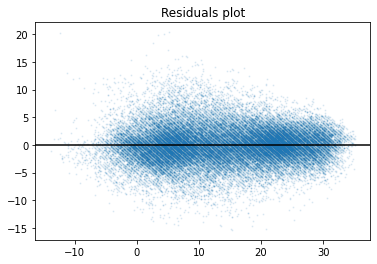

In [ ]:
delta_y = y_train - y_pred
plt.scatter(y_pred, delta_y, alpha=.1, s=1)
plt.axhline(0, color='black')
plt.title("Residuals plot")

The residuals plot shows errors uniformly distributed around the centerline.  The plot does not show significant evidence of uncaptured explanatory information.

# Problem 5: Evaluation
Train the model with the highest accuracy score with the full training dataset.  Score the test data against this model.  Does the model demonstrate predictive validity?

As we have seen before, we fit the highest-performing model to the test data and score performance against the test dataset.

In [ ]:
best_estimator = estimators["xgb"]
best_estimator.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=None, n_estimators=400,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=3, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
best_estimator.score(X_test, y_test)

0.9066871802195556

The final score is comparable to the training score.

While not required for the homework question, we can also show the actual and predicted values from the final `xgb` model, which illustrates strong predictive alignment:

Text(0.5, 1.0, 'Predicted')

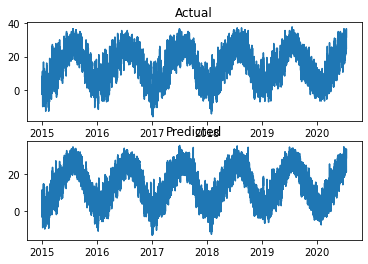

In [ ]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(wdf["date"], y)
ax[0].set_title("Actual")
y_pred = best_estimator.predict(xt)
ax[1].plot(wdf["date"], y_pred)
ax[1].set_title("Predicted")